# ファクターモデルの応用

In [76]:
ENV["LINES"] = 10
ENV["COLUMNS"] = 1000
using DataFrames, DataFramesMeta, Gadfly, CSV, GLM, Statistics, ShiftedArrays, CategoricalArrays, StatsBase, Convex, LinearAlgebra, SCS

In [2]:
monthly_data_df = CSV.File("../../data/ch05_output1.csv", missingstring="NA") |> DataFrame
annual_data_df = CSV.File("../../data/ch05_output2.csv", missingstring="NA") |> DataFrame
factor_data_df = CSV.File("../../data/ch06_output.csv", missingstring="NA") |> DataFrame

,month_ID,R_F,R_M,R_Me,SMB,HML
,Int64,Float64,Float64,Float64,Float64,Float64
1,13,4.3277e-5,0.0458354,0.0457922,-0.00178152,0.00199843
2,14,3.46435e-5,0.0284234,0.0283888,-0.00669601,0.0157772
3,15,3.93186e-5,-0.0579765,-0.0580158,0.046491,0.0197889
4,16,6.62327e-5,-0.00107183,-0.00113806,-0.0362135,0.0341131
5,17,3.60107e-5,-0.006416,-0.00645201,-0.0222042,0.0169759
6,18,2.57205e-5,-0.0370747,-0.0371004,0.0170795,0.00231842
7,19,5.37206e-5,0.0298533,0.0297996,-0.014849,-0.0250261
8,20,0.000101568,0.0537568,0.0536552,-0.00211152,-0.0166064
9,21,8.20293e-5,0.0236503,0.0235682,0.0422022,-0.00915376


In [3]:
#ch07_01
temp_monthly_data_df = @chain monthly_data_df begin
    groupby(:firm_ID)
    @transform begin
        :is_public2020 = maximum(:month_ID) == 72
        :N_observations = length(:month_ID)
    end
    @rsubset(:is_public2020 == true, :N_observations >= 36)
    @select($(Not(:N_observations)))
end
temp_annual_data_df = @chain temp_monthly_data_df begin
    @select(:year, :firm_ID)
    leftjoin(annual_data_df, on = [:year, :firm_ID])
end

,year,firm_ID,R,Re,R_F,industry_ID,sales,OX,NFE,X
,Int64,Int64,Float64?,Float64?,Float64?,Int64?,Float64?,Float64?,Float64?,Float64?
1,2015,1,missing,missing,0.00743209,missing,missing,missing,missing,missing
2,2015,1,missing,missing,0.00743209,missing,missing,missing,missing,missing
3,2015,1,missing,missing,0.00743209,missing,missing,missing,missing,missing
4,2015,1,missing,missing,0.00743209,missing,missing,missing,missing,missing
5,2015,1,missing,missing,0.00743209,missing,missing,missing,missing,missing
6,2015,1,missing,missing,0.00743209,missing,missing,missing,missing,missing
7,2015,1,missing,missing,0.00743209,missing,missing,missing,missing,missing
8,2015,1,missing,missing,0.00743209,missing,missing,missing,missing,missing
9,2015,1,missing,missing,0.00743209,missing,missing,missing,missing,missing


In [4]:
#ch07_02
regression_data_df = @chain temp_monthly_data_df begin
    @select($(Not(:R_F)))
    innerjoin(factor_data_df, on = [:month_ID])
end

result_df = DataFrame()
for firm_ID_i in unique(regression_data_df.firm_ID)
    tmp_df = @rsubset(regression_data_df, :firm_ID == firm_ID_i)
    result = lm(@formula(Re ~ 0 + R_Me + SMB + HML), tmp_df)
    tmp_df = coeftable(result) |> DataFrame
    insertcols!(tmp_df, 1, :firm_ID => firm_ID_i)
    append!(result_df, tmp_df)
end

In [5]:
result_df

,firm_ID,Name,Coef.,Std. Error,t,Pr(>|t|),Lower 95%,Upper 95%
,Int64,Any,Float64,Float64,Float64,Float64,Float64,Float64
1,1,R_Me,1.61856,0.316748,5.10992,3.89767e-6,0.984278,2.25283
2,1,SMB,2.63632,0.561508,4.69508,1.71889e-5,1.51192,3.76072
3,1,HML,0.477299,0.670194,0.71218,0.479258,-0.864741,1.81934
4,2,R_Me,1.23947,0.24658,5.02664,5.26776e-6,0.7457,1.73324
5,2,SMB,0.49989,0.43712,1.1436,0.25757,-0.375427,1.37521
6,2,HML,-0.528299,0.521729,-1.01259,0.315534,-1.57304,0.516445
7,3,R_Me,0.695867,0.232792,2.98922,0.00412264,0.229708,1.16203
8,3,SMB,1.14033,0.412678,2.76324,0.00769255,0.313955,1.9667
9,3,HML,0.330054,0.492556,0.670084,0.50551,-0.656272,1.31638


In [6]:
#ch07_03
beta_df = @chain result_df begin
    unstack(:firm_ID, :Name, "Coef.")
end

,firm_ID,R_Me,SMB,HML
,Int64,Float64?,Float64?,Float64?
1,1,1.61856,2.63632,0.477299
2,2,1.23947,0.49989,-0.528299
3,3,0.695867,1.14033,0.330054
4,4,0.375284,0.49782,-0.437296
5,5,0.583064,1.5306,1.11493
6,7,0.380234,0.919835,-0.301411
7,8,0.223154,-0.0515262,-0.1122
8,9,0.64852,0.548404,-0.0804305
9,10,0.922558,1.2062,0.36374


In [7]:
#ch07_04
premium_df = @chain factor_data_df begin
    @select(:R_Me, :SMB, :HML)
    @rtransform begin
        :R_Me = 12 * :R_Me
        :SMB = 12 * :SMB
        :HML = 12 * :HML
    end
end

,R_Me,SMB,HML
,Float64,Float64,Float64
1,0.549506,-0.0213783,0.0239812
2,0.340666,-0.0803521,0.189326
3,-0.696189,0.557892,0.237467
4,-0.0136568,-0.434562,0.409357
5,-0.0774241,-0.26645,0.203711
6,-0.445204,0.204954,0.0278211
7,0.357595,-0.178188,-0.300313
8,0.643863,-0.0253382,-0.199277
9,0.282819,0.506426,-0.109845


In [8]:
#ch07_05
cost_df = DataFrame(:firm_ID => beta_df.firm_ID, :cost => Matrix(beta_df[:, 2:4]) * mean.(eachcol(premium_df)))

,firm_ID,cost
,Int64,Float64?
1,1,0.324621
2,2,0.0547862
3,3,0.150504
4,4,0.0207171
5,5,0.241124
6,7,0.065435
7,8,-0.00268085
8,9,0.0675294
9,10,0.169368


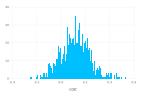

In [9]:
plot(cost_df, x = :cost, Geom.histogram)

In [10]:
#ch07_07
annual_data_2020_df = @chain annual_data_df begin
    groupby(:firm_ID)
    @transform(:lagged_ME = lag(:ME))
    @rsubset(:year == 2020)
    @transform begin
        :ME_rank2 = cut(:lagged_ME, 2, labels=1:2)
    end
    innerjoin(cost_df, on = :firm_ID)
    dropmissing
    groupby(:ME_rank2)
    @combine begin
        :mean = mean(:cost)
        :median = median(:cost)
    end
end

,ME_rank2,mean,median
,Cat…,Float64,Float64
1,1,0.133481,0.138251
2,2,0.104616,0.105466


In [11]:
#ch07_08
dy_2020_df = @chain monthly_data_df begin
    @rsubset(:year == 2020)
    @rtransform(:temp = :DPS * :shares_outstanding)
    groupby(:firm_ID)
    @combine begin
        :annual_div = sum(:temp)
        :latest_ME = last(:ME)
    end
    @rtransform(:dy = :annual_div / :latest_ME)
    @rsubset(:dy > 0)
end

,firm_ID,annual_div,latest_ME,dy
,Int64,Int64,Int64,Float64
1,1,325472000,9708946000,0.0335229
2,2,37536000,5194044000,0.00722674
3,3,4660110000,214032195000,0.0217729
4,4,101352000,8652927000,0.011713
5,5,745488000,235170402000,0.00316999
6,7,64848000,15909376000,0.00407609
7,8,394288000,9224264000,0.0427447
8,9,460168000,6884730000,0.0668389
9,10,700032000,12770115000,0.054818


In [12]:
#ch07_09
@chain dy_2020_df begin
    leftjoin(cost_df, on = :firm_ID)
    @rtransform begin
        :idg = (:cost - :dy) / (1 + :dy)
    end
end

,firm_ID,annual_div,latest_ME,dy,cost,idg
,Int64,Int64,Int64,Float64,Float64?,Float64?
1,1,325472000,9708946000,0.0335229,0.324621,0.281656
2,2,37536000,5194044000,0.00722674,0.0547862,0.0472182
3,3,4660110000,214032195000,0.0217729,0.150504,0.125988
4,4,101352000,8652927000,0.011713,0.0207171,0.0088998
5,5,745488000,235170402000,0.00316999,0.241124,0.237202
6,7,64848000,15909376000,0.00407609,0.065435,0.0611098
7,8,394288000,9224264000,0.0427447,-0.00268085,-0.0435634
8,9,460168000,6884730000,0.0668389,0.0675294,0.00064723
9,10,700032000,12770115000,0.054818,0.169368,0.108597


In [14]:
#ch07_10
covariance_M = @chain factor_data_df begin
    @select(:R_Me, :SMB, :HML)
    Matrix
    cov
end
covariance_M *= 12

3×3 Matrix{Float64}:
  0.020686    -0.00390161   0.00152989
 -0.00390161   0.00626838  -0.00188635
  0.00152989  -0.00188635   0.00391564

In [17]:
#ch07_11
NUMBER_OF_UNIVERSE = 100

investment_universe_df = @chain annual_data_df begin
    @rsubset(:year == 2020)
    @subset(ordinalrank(:ME, rev=true) .<= NUMBER_OF_UNIVERSE)
    @select(:firm_ID)
end

,firm_ID
,Int64
1,33
2,101
3,155
4,167
5,204
6,208
7,233
8,234
9,238


In [56]:
#ch07_12
svar_df = @chain monthly_data_df begin
    @rsubset(:firm_ID in investment_universe_df.firm_ID)
    leftjoin(beta_df, on = :firm_ID)
    @select(:firm_ID, :month_ID, :R, :R_Me, :SMB, :HML)
    rename(:R_Me => :beta_M, :SMB => :beta_SMB, :HML => :beta_HML)
    innerjoin(factor_data_df, on = :month_ID)
    @rtransform begin
        :R_FF3 = :R_F + :beta_M * :R_Me + :beta_SMB * :SMB + :beta_HML * :HML
    end
    @rtransform begin
        :epsilon = :R - :R_FF3
    end
    @select(:firm_ID, :epsilon)
    groupby(:firm_ID)
    @combine(:svar = var(:epsilon) * 12)
end
svar_M = diagm(svar_df.svar)

100×100 Matrix{Float64}:
 0.0608005  0.0        0.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0
 0.0        0.0843606  0.0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [62]:
#ch07_13
beta_M = @chain beta_df begin
    @rsubset(:firm_ID in investment_universe_df.firm_ID)
    @select(:R_Me, :SMB, :HML)
    Matrix
end

Sigma = beta_M * covariance_M * transpose(beta_M) + svar_M

100×100 Matrix{Float64}:
 0.0758546   0.00485917  0.0127152  0.0139881  0.0148248   0.00949494  0.0150974  0.0134943  0.014218    0.0214939  0.0125278  0.0242402  0.0066145   0.016053   0.0140464  0.0178108  0.0156868  0.0201805  0.0187955  0.0108124  0.0215833  0.0162454  0.0203705  0.0210979  0.0231006  0.017454   0.00846198  0.00724284  0.0188866  0.0245482  0.0102885   0.021295   0.0109638   0.0133414   0.0113681   0.0195314  0.0257301  0.0148369  0.017361    0.00921057  0.0112553  0.00753092  0.0182148  0.00592716  …  0.0111225   0.012782    0.0194685  0.00435077  0.0181065   0.00771959  0.00855872  0.0100505   0.0128129   0.0199406   -0.00114931  0.00573287  0.0132873  0.00716358  0.0126913   0.00756176  0.0117922  0.00274667  0.00843147  0.0119811  0.0104133   0.025574   0.0128917  0.0198707  0.0116747  0.0120483   0.0136448  0.0125998  0.0247154  0.016322   0.0262815  0.025236   0.0146123  0.0225105  0.00982528  0.0188072  0.0256959  0.0134071  0.0173057  0.0128532  0.0141542  

In [65]:
#ch07_14
mu_M = @chain cost_df begin
    @rsubset(:firm_ID in investment_universe_df.firm_ID)
    @select(:cost)
    Matrix
end

100×1 Matrix{Union{Missing, Float64}}:
  0.20379167767828044
 -0.0017508604735760082
  0.07184642979589449
  ⋮
  0.15310033108823778
  0.3616627580838979

In [91]:
#ch07_16
w = Variable(100)
ret = dot(w, convert(Array{Float64}, mu_M))
risk = quadform(w, Hermitian(Sigma))
p = minimize(risk, sum(w) == 1, ret >= 0.1)
solve!(p, SCS.Optimizer)

------------------------------------------------------------------
	       SCS v3.2.0 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 103, constraints m: 108
cones: 	  z: primal zero / dual free vars: 2
	  l: linear vars: 2
	  q: soc vars: 104, qsize: 2
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct
	  nnz(A): 10206, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 1.71e+01  1.00e+00  1.61e+01 -8.06e+00  1.00e-01  8.81e-04 
    75| 1.15e-04  2.74e-06  1.18e-05  7.00e-03  1.00e-01  3.58e-02 
--------------

In [97]:
#ch07_18
optimal_weight = w.value
println(optimal_weight[1:10])

minimized_risk = sqrt(p.optval)

[0.05806895277259258, 0.024548954386657804, 0.012148665929079601, -0.027089694074814465, 0.012375197971523791, -0.17030941669966612, 0.01187701639802282, 0.012862720553548819, 0.051794894793923345, -0.011140862315866067]


0.08364116693348297

In [108]:
#ch07_19
target_return = collect(range(-0.1, 0.4, length=100))
N_points = length(target_return)
optimal_weight_M = zeros(N_points, NUMBER_OF_UNIVERSE)
minimized_risk = zeros(N_points)

for (i, target_return_i) in enumerate(target_return)
    w = Variable(100)
    ret = dot(w, convert(Array{Float64}, mu_M))
    risk = quadform(w, Hermitian(Sigma))
    p = minimize(risk, sum(w) == 1, ret >= target_return_i)
    solve!(p, SCS.Optimizer)
    optimal_weight_M[i, :] = transpose(w.value)
    minimized_risk[i] = sqrt(p.optval)
end

------------------------------------------------------------------
	       SCS v3.2.0 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 103, constraints m: 108
cones: 	  z: primal zero / dual free vars: 2
	  l: linear vars: 2
	  q: soc vars: 104, qsize: 2
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct
	  nnz(A): 10206, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 1.71e+01  1.00e+00  1.61e+01 -8.06e+00  1.00e-01  2.06e-04 
    75| 6.22e-05  1.41e-06  4.62e-06  4.14e-03  1.00e-01  5.49e-03 
--------------

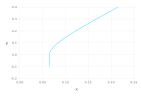

In [109]:
#ch07_20
plot(x = minimized_risk, y = target_return, Geom.line)

In [110]:
minimized_risk

100-element Vector{Float64}:
 0.06434045970827348
 0.06434041481496366
 0.06434037213408031
 ⋮
 0.21235307006431084
 0.21478368096302686